In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from multiprocessing import Pool
import tensorflow as tf
from tensorflow.python.ops import nn


py_file_location = "..."
os.path.abspath(os.path.join(os.path.dirname(py_file_location), os.path.pardir))

#from packages import *
#from parameters import *

from model_DL import *
from functions import *
from metrics import *
from DNN_metrics import *
from data_generator import *
from loss_function import *
from optimization import *
from utils import * 


tf.device('GPU:1') 

In [3]:
Nbr_test_bruteforce = 10000


Nbr_train = int(1E6)

Nbr_test = int(2E5) 



project_sub_path = "ALL_NOISY/DF/"
  
# Parent Directory path
parent_dir = ""
### Train ###
#dataset_train_Anne
dataset_train = np.load(os.path.join(parent_dir,project_sub_path,'dataset_train_GF.npz'))

h_11_tr = dataset_train['h_PP'][:Nbr_train]
h_12_tr = dataset_train['h_PS'][:Nbr_train]
h_1R_tr = dataset_train['h_PR'][:Nbr_train]
h_21_tr = dataset_train['h_SP'][:Nbr_train]
h_22_tr = dataset_train['h_SS'][:Nbr_train]
h_2R_tr = dataset_train['h_SR'][:Nbr_train]
h_R1_tr = dataset_train['h_RP'][:Nbr_train]
h_R2_tr = dataset_train['h_RS'][:Nbr_train]


#x_train_input = np.stack([h_11_tr, h_12_tr, h_1R_tr, h_21_tr, h_22_tr, h_2R_tr, h_R1_tr, h_R2_tr], axis=1)
x_train = np.stack([h_R1_tr, h_11_tr, h_2R_tr, h_1R_tr, h_22_tr, h_R2_tr, h_21_tr, h_12_tr], axis=1)






#dataset_val_Anne

dataset_test = np.load(os.path.join(parent_dir,project_sub_path,'dataset_val_GF.npz'))

h_11_test = dataset_test['h_PP'][:Nbr_test_bruteforce]
h_12_test = dataset_test['h_PS'][:Nbr_test_bruteforce]
h_1R_test = dataset_test['h_PR'][:Nbr_test_bruteforce]
h_21_test = dataset_test['h_SP'][:Nbr_test_bruteforce]
h_22_test = dataset_test['h_SS'][:Nbr_test_bruteforce]
h_2R_test = dataset_test['h_SR'][:Nbr_test_bruteforce]
h_R1_test = dataset_test['h_RP'][:Nbr_test_bruteforce]
h_R2_test = dataset_test['h_RS'][:Nbr_test_bruteforce]

x_test = np.stack([h_R1_test, h_11_test, h_2R_test, h_1R_test, h_22_test, h_R2_test, h_21_test, h_12_test], axis=1)




# Load DF Data

In [4]:
# First, load ... 
# useful for DNN prediction because DNN takes H as input 

outfile_NH_MATRIX_DF = 'ALL_NOISY/DF/NH_MATRIX_GF_CDIT'

NH_MATRIX_DF = np.load(outfile_NH_MATRIX_DF+".npz")
NH_MATRIX_DF.files
NH_MATRIX_DF = NH_MATRIX_DF['arr_0']

# Noisy_H ==> NH_MATRIX

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation ...  because it containing (Alpha, Pr, Ps) 


outfile_BF_NG_MATRIX_DF = 'ALL_NOISY/DF/BF_NG_MATRIX_GF_CDIT'

dataset_test_DF = np.load(outfile_BF_NG_MATRIX_DF+".npz")
dataset_test_DF.files
dataset_test_DF = dataset_test_DF['arr_0']

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation, because it containing G Matrix without noise 


outfile_BF_G_Benchmark_DF = 'ALL_NOISY/DF/BF_G_Benchmark_GF_CDIT'

dataset_DF = np.load(outfile_BF_G_Benchmark_DF+".npz")
dataset_DF.files
dataset_DF = dataset_DF['arr_0']







In [5]:

#-----------------------------------------------------------------------------------------#


def relative_avreage_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return (np.mean(X) - np.mean(Y))/(np.mean(Y))

def avreage_relative_gap(X, Y):
  """relative avreage gap between the predicted debit and the obtained debit based on bruteforce"""

  return np.mean((X-Y)/Y)

#-----------------------------------------------------------------------------------------#


def opportunistic_rate_for_noisy_channels(datas, labels):
    '''
    Parameters: 
        dataset : test_set
        labels : For DNN estimations
    '''
    H_matrix = []
    opportunistic_rate = []
    # create H_matrix ( without noise ) for each noise level labels
    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
        
    # calculate rate for the same H with different labels based on noise level
    for i,j in zip(H_matrix,labels) : 
        data , label = i[:,0:8], j[:,8:12]
        temp_rate = rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], np.sqrt(label[:,1]), np.sqrt(label[:,2]), np.sqrt(label[:,3]))
        opportunistic_rate.append(temp_rate)
        
    return np.asarray(opportunistic_rate, dtype="float64")



def plot_CSI_Imperfect_Stats(res_stats, plot_lab, x_lab, y_lab, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(SNRs_db, res_stats, c = 'black',label= plot_lab)

    ax.grid()

    ax.scatter(SNRs_db[0],res_stats[0],label=r'$SNR=-10$',s=200,marker='v',linewidths=1)

    ax.scatter(SNRs_db[1],res_stats[1],label=r'$SNR=-5}$',s=200,marker='o',linewidths=1)

    ax.scatter(SNRs_db[2],res_stats[2],label=r'$SNR=0$',s=200,marker='D',linewidths=1)

    ax.scatter(SNRs_db[3],res_stats[3],label='$SNR=5$',s=200,marker='H',linewidths=1)

    ax.scatter(SNRs_db[4],res_stats[4],label='$SNR=10$',s=200,marker='d',linewidths=1)

    ax.scatter(SNRs_db[5],res_stats[5],label='$SNR=15$',s=200,marker='P',linewidths=1)

    ax.scatter(SNRs_db[6],res_stats[6],label='$SNR=20$',s=200,marker='<',linewidths=1)

    #ax.scatter(var[7],res_stats[7],label='$\sigma=10^{1.5}$',s=200,marker='>',linewidths=1)

    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(loc='best', fontsize=16)

    plt.xlabel(x_lab, fontsize=24) #'Noise variance','Percentage'
    plt.ylabel(y_lab, fontsize=24)
    #plt.xscale('log')
    

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/RAG_opportunistic_rate.pdf', bbox_inches='tight')

    



# GAP DB BF

In [6]:

SNRs_db = [-10, -5, 0, 5, 10, 15, 20]

db_bruteforce = opportunistic_rate_for_noisy_channels(dataset_DF, dataset_test_DF) 
# rate for H without noise
db_benchmark = rate(dataset_DF[:,0], dataset_DF[:,1], dataset_DF[:,2], dataset_DF[:,3], dataset_DF[:,4], dataset_DF[:,5], dataset_DF[:,6], dataset_DF[:,7], np.sqrt(dataset_DF[:,9]), np.sqrt(dataset_DF[:,10]), np.sqrt(dataset_DF[:,11]))

# List of relative gap between each noisy matrix and benchmark (BF results without noise)

db_gap_DF = np.array([relative_avreage_gap(db_bruteforce[0,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[1,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[2,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[3,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[4,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[5,:,8], db_benchmark[:,8]),\
                   relative_avreage_gap(db_bruteforce[6,:,8], db_benchmark[:,8])])

db_gap_DF = db_gap_DF*100



In [7]:
def primary_rate(Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Alpha, Pr, Ps, Pp=10.0):
    """
      Parameters:
         Grp: 1D Array containing Alpha values.
         Gpp: 1D Array containing Gain between primary transmitter and primary receiver.
         Gsp: 1D Array containing Gain between secondary transmitter and primary receiver.
         Alpha: 1D Array containing Alpha values.
         Pr: 1D Array containing Power of relay.
         Ps: 1D Array containing Power of secondary network.

      Returns:
         primary debit.

    """
    Rp = C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Ps*Pr*Alpha)+1))
    return Rp



def mean_max_outage_PARD(N_P_Rate, Max_P_Rate, tau = 0.25):
    '''
    N_PRate : Primary rate based on bruteforce output (Alpha, Pr, Ps) where BF is computed using noisy channels 
    Max_P_Rate : Primary rate without secondary users interference
    '''
    res = 1-(N_P_Rate/Max_P_Rate) # Compute of Delta
    
    #res = np.round(res,4)
    mean_res = np.nanmean(res) # Mean of Delta 
    max_res = np.max(res) # Max of Delta
    #res =  # Outage
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            mean_outage = np.nanmean(res[res>tau])
        except RuntimeWarning:
            mean_outage = 0
            
    outage = np.nanmean(res>tau)
    
    return mean_res, max_res, mean_outage, outage


def PARD_for_noisy_data(datas, labels, Pp=10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j[:,8:12]
        
        N_P_Rate = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], np.sqrt(label[:,1]), np.sqrt(label[:,2]), np.sqrt(label[:,3]))
        
        P_Rate_max = C(data[:,1]*Pp) # data[:,1] tend for G_PP
        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100

def plot_ARPD(mean_ARPD, maximum_ARPD, mean_outage_ARPD, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    
    fig, ax = plt.subplots(1,figsize=(15,7))

    ax.plot(SNRs_db, maximum_ARPD, c = 'blue',label=r"$Max$",lw=2.5)
    ax.plot(SNRs_db, mean_ARPD, c = 'red',label=r"$Mean$",lw=2.5)
    ax.plot(SNRs_db, mean_outage_ARPD, c = 'gray',label=r"$Mean\; outage$",lw=2.5)

    ax.grid()

    xs = np.linspace(1, 10**1.5, 20)

    plt.hlines(y=25, xmin=-10, xmax=len(xs), colors='black', linestyles='--', lw=2, label=r'$\tau = 25\%$')


    ax.tick_params(axis='x', labelsize=16 )
    ax.tick_params(axis='y', labelsize=16)



    ax.legend(loc='upper center', fontsize=16)

    plt.xlabel('SNR (dB)', fontsize=24)
    plt.ylabel('Primary network degradation (%)', fontsize=24)
    #plt.xscale('log')

    #fig.savefig('Datasetv2/Bruteforce/Dataset_for_BF/PDD.pdf', bbox_inches='tight')



Mean_ARPD_DF, Max_ARPD_DF, Mean_Outage_ARPD_DF, Outage_ARPD_DF = PARD_for_noisy_data(dataset_DF,dataset_test_DF)



In [8]:
def DNN_predictions(NH_MATRIX, mw_path, Lambda=10**0.5, tau = 0.25):
    '''
    NH_MATRIX : Noisy H matrix 
    '''
    final_predictions = []
   
  
    # selection of the desired model
    # A :  "Weights_Model/CSI imperfection/DNN_GF.h5"
    # B : Weights_Model/CSI imperfection/Lambda/LD_10_0_5_ANNE.h5
    # Load model
    model = tf.keras.models.load_model(mw_path, custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})
    
    for i in NH_MATRIX : 
        data = i[:,0:8]
        temp_predictions = model.predict(data)
        final_predictions.append(temp_predictions)
        
    return np.asarray(final_predictions, dtype="float64")

def opportunistic_rate_for_noisy_channels_DNN(datas, labels):
    '''
    dataset : H matrix without noise
    labels : predicted parameters (Alpha, Pr, Ps)
    #  Warning : rate is computed using y_hat not sqrt(y_hat) like opportunistic_rate_for_noisy_channels function

    '''
    final_rate = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data , y_hat = i[:,0:8], j
        temp_rate = rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0], y_hat[:,1], y_hat[:,2])
        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float64")

def primary_degradation_for_noisy_data_DNN(datas, labels):
    final_pdd = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data, y_hat = i[:,0:8], j
        temp_pdd = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0], y_hat[:,1], y_hat[:,2])
        final_pdd.append(temp_pdd)
        
    return np.asarray(final_pdd, dtype="float64")




In [9]:
#"weights_model/gaussian_fading_model/anne_model.h5"
Model_Weight_Path = "ALL_NOISY/DF/GF_model.h5"

DNN_pred_DF = DNN_predictions(NH_MATRIX_DF, Model_Weight_Path)
db_DNN = opportunistic_rate_for_noisy_channels_DNN(dataset_DF, DNN_pred_DF)
db_benchmark = rate(dataset_DF[:,0], dataset_DF[:,1], dataset_DF[:,2], dataset_DF[:,3], dataset_DF[:,4], dataset_DF[:,5], dataset_DF[:,6], dataset_DF[:,7], np.sqrt(dataset_DF[:,9]), np.sqrt(dataset_DF[:,10]), np.sqrt(dataset_DF[:,11]))


db_gap_DNN_DF = np.array([relative_avreage_gap(db_DNN[0,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[1,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[2,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[3,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[4,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[5,:,8], db_benchmark[:,8]),\
                       relative_avreage_gap(db_DNN[6,:,8], db_benchmark[:,8])])
#,\
#                       relative_avreage_gap(db_DNN[7,:,8], db_benchmark[:,8])


#ax.plot(variance, db_gap, c = 'blue',label='BF')

db_gap_DNN_DF = db_gap_DNN_DF*100



2022-03-14 11:22:42.334924: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 41.53G (44597237504 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-03-14 11:22:42.337331: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 37.38G (40137510912 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-03-14 11:22:42.339669: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 33.64G (36123758592 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-03-14 11:22:42.342024: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 30.28G (32511381504 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-03-14 11:22:42.344359: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to allocate 27.25G (29260242944 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-03-14 11:22:42.346721: I tensorflow/stream_executor/cuda/cuda_driver.cc:789] failed to all

In [10]:
def PARD_for_noisy_data_DNN(datas, labels, Pp = 10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j # j not j[:,8:12]
        # label for primary_rate not sqrt label
        N_P_Rate = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1], label[:,2])

        P_Rate_max = C(data[:,1]*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100




Mean_ARPD_DNN_DF, Max_ARPD_DNN_DF, Mean_Outage_ARPD_DNN_DF, Outage_ARPD_DNN_DF = PARD_for_noisy_data_DNN(dataset_DF, DNN_pred_DF)




In [11]:
# BF : 

# db_gap_DF
#Mean_ARPD_DF, Max_ARPD_DF, Mean_Outage_ARPD_DF, Outage_ARPD_DF 

 
# DNN : 

# db_gap_DNN_DF
# Mean_ARPD_DNN_DF, Max_ARPD_DNN_DF, Mean_Outage_ARPD_DNN_DF, Outage_ARPD_DNN_DF

# Load CF Data

In [12]:
# First, load ... 
# useful for DNN prediction because DNN takes H as input 

outfile_NH_MATRIX_CF = 'ALL_NOISY/CF/NH_MATRIX_GF_CDIT'

NH_MATRIX_CF = np.load(outfile_NH_MATRIX_CF+".npz")
NH_MATRIX_CF.files
NH_MATRIX_CF = NH_MATRIX_CF['arr_0']

# Noisy_H ==> NH_MATRIX

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation ...  because it containing (Alpha, Pr, Ps) 


outfile_BF_NG_MATRIX_CF = 'ALL_NOISY/CF/BF_NG_MATRIX_GF_CDIT'

dataset_test_CF = np.load(outfile_BF_NG_MATRIX_CF+".npz")
dataset_test_CF.files
dataset_test_CF = dataset_test_CF['arr_0']

#-----------------------------------------------------------------------------------------#
# useful for Rate, outage, Delta calculation, because it containing G Matrix without noise 


outfile_BF_G_Benchmark_CF = 'ALL_NOISY/CF/BF_G_Benchmark_GF_CDIT'

dataset_CF = np.load(outfile_BF_G_Benchmark_CF+".npz")
dataset_CF.files
dataset_CF = dataset_CF['arr_0']







In [13]:
#-----------------------------------------------------------------------------------------#


def opportunistic_rate_for_noisy_channels_CF(datas, labels):
    '''
    Parameters: 
        dataset : test_set
        labels : For DNN estimations
    '''
    H_matrix = []
    opportunistic_rate = []
    # create H_matrix ( without noise ) for each noise level labels
    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
        
    # calculate rate for the same H with different labels based on noise level
    for i,j in zip(H_matrix,labels) : 
        data , label = i[:,0:8], j[:,8:12]
        temp_rate = C(f_obj(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1]))

        opportunistic_rate.append(temp_rate)
        
    return np.asarray(opportunistic_rate, dtype="float64")


def primary_rate_CF(hR1, h11, h2R, h1R, h22, hR2, h21, h12, PR, PS, P1 = 10.0):

    R_P = C((h11**2*P1)/(hR1**2*PR+h21**2*PS+1))

    return R_P




def mean_max_outage_PARD_CF(N_P_Rate, Max_P_Rate, tau = 0.25):
    '''
    N_PRate : Primary rate based on bruteforce output (Alpha, Pr, Ps) where BF is computed using noisy channels 
    Max_P_Rate : Primary rate without secondary users interference
    '''
    res = 1-(N_P_Rate/Max_P_Rate) # Compute of Delta
    
    #res = np.round(res,4)
    mean_res = np.nanmean(res) # Mean of Delta 
    max_res = np.max(res) # Max of Delta
    #res =  # Outage
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            mean_outage = np.nanmean(res[res>tau])
        except RuntimeWarning:
            mean_outage = 0
            
    outage = np.nanmean(res>tau)
    
    return mean_res, max_res, mean_outage, outage






In [14]:
db_bruteforce = opportunistic_rate_for_noisy_channels_CF(dataset_CF, dataset_test_CF) 

# rate for H without noise
db_benchmark = C(f_obj(dataset_CF[:,0], dataset_CF[:,1], dataset_CF[:,2], dataset_CF[:,3], dataset_CF[:,4], dataset_CF[:,5], dataset_CF[:,6], dataset_CF[:,7], dataset_CF[:,8], dataset_CF[:,9]))


# List of relative gap between each noisy matrix and benchmark (BF results without noise)

db_gap_CF = np.array([relative_avreage_gap(db_bruteforce[0,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[1,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[2,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[3,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[4,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[5,:], db_benchmark[:]),\
                   relative_avreage_gap(db_bruteforce[6,:], db_benchmark[:])])

db_gap_CF = db_gap_CF*100



In [15]:

def PARD_for_noisy_data_CF(datas, labels, Pp=10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j[:,8:11]
        N_P_Rate = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1])
        
        P_Rate_max = C(data[:,1]**2*Pp) # data[:,1] tend for G_PP
        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100



Mean_ARPD_CF, Max_ARPD_CF, Mean_Outage_ARPD_CF, Outage_ARPD_CF = PARD_for_noisy_data_CF(dataset_CF,dataset_test_CF)




In [16]:
#------------ tensorflow functions for DNN ------------# 
def custom_sigmoid(x):
    """
    Modified sigmoid function used for handling predicted powers.

    Parameters:
      x: tensor.
    Returns:
      Output of sigmoid function range between 0 and sqrt(10)
    """
    output = tf.multiply(tf.sqrt(tf.constant(10,dtype=tf.float32)),nn.sigmoid(x))
    # Cache the logits to use for crossentropy loss.
    output._keras_logits = x  # pylint: disable=protected-access
    return output




def log2(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(2, dtype=tf.float32))
    return numerator / denominator


def Delta_DNN(G, y_out):
 
    """
      Metrics used on DL model for Primary achievable rate degradation.
      
      Parameters:
        G: Channel gain tensor.
        y_out: Predicted parameter.
      Returns:
        Primary achievable rate degradation for each samples 
    """
    G = tf.cast(G, dtype='float32')
    y_out = tf.cast(y_out, dtype='float32')
    
    # index retrieval


    Grp_indx, Gpp_indx, Gsp_indx = [0], [1], [6]
    Pr_indx, Ps_indx  = [0], [1]

    # tensors retrieval
    Grp, Gpp, Gsp, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsp_indx, axis=1),  tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)
    
    
    #  Pp Creation
    Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10)
    
    # Rp : C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Alpha*Ps*Pr)+1) ==> C(H1/H2), where H1 = Gpp*Pp and H2 = R1+R2+1
    H1 = tf.multiply(Gpp, Pp)

    R1 =  tf.add(tf.multiply(Grp, tf.pow(Pr, 2)),tf.multiply(Gsp,tf.pow(Ps, 2)))

    H2 = tf.add(R1, tf.constant(1,dtype=tf.float32))
    
    SNR_P = tf.divide(H1, H2)
    
    Rp =  tf.multiply(tf.constant(0.5, dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_P)))

    # Rp_ : C(Gpp*Pp)
    SNR_P_ = tf.multiply(Gpp, Pp)
    Rp_ = tf.multiply(tf.constant(0.5,dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_P_)))
    # 1 - ratio(Rp, Rp_)
    RRP = tf.subtract(tf.constant(1,dtype=tf.float32), tf.divide(Rp, Rp_))
    
    return RRP



def Opportunistic_Achievable_Rate(v_tau):
    def opportunistic_rate(G, y_out):
        """
        Metrics used on DL model for throughput calculation.
        This function will get those parameters as input
        G: Channel gain tensor.
        y_out: Predicted parameter.

        Parameters:
        Lambda : Penalty for QoS
        Tau : degradation factor for the primary network
        Returns:
        Throughput mean 
        """

        Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 

        G = tf.cast(G, dtype='float32')
        y_out = tf.cast(y_out, dtype='float32')

        # index retrieval
    


        Grp_indx, Gpp_indx, Gsr_indx, Gpr_indx, Gss_indx, Grs_indx, Gsp_indx, Gps_indx = [0], [1], [2], [3], [4], [5], [6], [7]
        Pr_indx, Ps_indx  = [0], [1]

        # tensors retrieval
        Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsr_indx, axis=1), tf.gather(G, Gpr_indx, axis=1), tf.gather(G, Gss_indx, axis=1), tf.gather(G, Grs_indx, axis=1), tf.gather(G, Gsp_indx, axis=1), tf.gather(G, Gps_indx, axis=1), tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)
        Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10)


        NS_Tilde = tf.add(tf.multiply(Gps,Pp),tf.constant(1, dtype=tf.float32))

        #NR_Tilde : gPR*PP +1

        NR_Tilde = tf.add(tf.multiply(Gpr,Pp),tf.constant(1, dtype=tf.float32))

        # Rho_Z : sqrt(Gpr*Gps)*Pp/sqrt(NR_tilde*NS_tilde)

        Rho_Z = tf.divide(tf.multiply(tf.sqrt(tf.multiply(Gpr,Gps)),Pp),tf.sqrt(tf.multiply(NR_Tilde,NS_Tilde)))


        #K1 : Gsr*NS_Tilde+Gss*NR_Tilde-2*Rho_Z*sqrt(Gsr*Gss*NR_Tilde*NS_Tilde)

        E1 = tf.add(tf.multiply(Gsr,NS_Tilde),tf.multiply(Gss,NR_Tilde))

        E2 = tf.sqrt(tf.multiply(tf.multiply(tf.multiply(Gsr,Gss),NR_Tilde),NS_Tilde))

        K1 = tf.math.subtract(E1,tf.multiply(tf.multiply(tf.constant(2, dtype=tf.float32),Rho_Z),E2))

        #K2 : (1-Rho_Z**2)*NR_Tilde*NS_Tilde

        K2 = tf.multiply(tf.math.subtract(tf.constant(1, dtype=tf.float32),tf.pow(Rho_Z,tf.constant(2, dtype=tf.float32))),tf.multiply(NR_Tilde,NS_Tilde))

        num = tf.add(tf.multiply(tf.multiply(tf.multiply(K1,Grs),tf.pow(Ps,2)),tf.pow(Pr,2)),tf.add(tf.multiply(tf.multiply(Gss,tf.pow(Ps,2)),tf.multiply(K1,tf.pow(Ps,2))),tf.multiply(tf.multiply(Gss,tf.pow(Ps,2)),K2)))
                
        d_num = tf.add(tf.multiply(tf.multiply(K2,Grs), tf.pow(Pr,2)),tf.add(tf.multiply(NS_Tilde,tf.multiply(K1,tf.pow(Ps,2))),tf.multiply(NS_Tilde,K2)))
        
        SNR_opt = tf.divide(num, d_num)

        #C = 1/2*log2(1+SNR_opt)
        # debit calculation
        Rs = tf.multiply(tf.constant(0.5,dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_opt)))
        return Rs
    return opportunistic_rate


def outage_percentage(v_tau): 
    def outage_percentage(G, y_out): 
        """
          metrics used on DL model for testing Primary achievable rate degradation percentage .

          Parameters:
            G: Channel gain tensor.
            y_out: Predicted parameter.
          Returns:
            percentage of Primary achievable rate degradation 
        """
        Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 

        G = tf.cast(G, dtype='float32')

        y_out = tf.cast(y_out, dtype='float32')

        # index retrieval


        Grp_indx, Gpp_indx, Gsp_indx = [0], [1], [6]
        Pr_indx, Ps_indx  = [0], [1]

        # tensors retrieval
        Grp, Gpp, Gsp, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsp_indx, axis=1),  tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)


        #  Pp Creation
        Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10)

        # Rp : C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Alpha*Ps*Pr)+1) ==> C(H1/H2), where H1 = Gpp*Pp and H2 = R1+R2+1
        H1 = tf.multiply(Gpp, Pp)

        R1 =  tf.add(tf.multiply(Grp, tf.pow(Pr, 2)),tf.multiply(Gsp,tf.pow(Ps, 2)))

        H2 = tf.add(R1, tf.constant(1,dtype=tf.float32))

        SNR_P = tf.divide(H1, H2)

        Rp =  tf.multiply(tf.constant(0.5, dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_P)))

        # Rp_ : C(Gpp*Pp)
        SNR_P_ = tf.multiply(Gpp, Pp)
        Rp_ = tf.multiply(tf.constant(0.5,dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_P_)))
        # 1 - ratio(Rp, Rp_)
        RRP = tf.subtract(tf.constant(1,dtype=tf.float32), tf.divide(Rp, Rp_))

        # 1 - ratio(Rp, Rp_)
        ARD = tf.subtract(tf.constant(1,dtype=tf.float32), tf.divide(Rp, Rp_))

        #ARD > tau  
        mask_PDD = tf.greater(ARD, Tau)# boolean array 

        return mask_PDD #*100 ?? 

    return outage_percentage


def QoS_Violation(v_tau, QoS_thresh = -5): 
    def V_Qos(G, y_out): 
        """
        metrics used on DL model for testing QoS viloation .

        Parameters:
            G: Channel gain tensor.
            y_out: Predicted parameter.
        Returns:
            Number of violated QoS 
        """
        Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 

        W = tf.constant(Lambda, dtype=tf.float32)  # ==> lambda 

        G = tf.cast(G, dtype='float32')

        y_out = tf.cast(y_out, dtype='float32')

        # index retrieval

        Grp_indx, Gpp_indx, Gsr_indx, Gpr_indx, Gss_indx, Grs_indx, Gsp_indx, Gps_indx  = [0], [1], [2], [3], [4], [5], [6], [7]

        Pr_indx, Ps_indx  = [0], [1]

        # tensors retrieval

        Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsr_indx, axis=1), tf.gather(G, Gpr_indx, axis=1), tf.gather(G, Gss_indx, axis=1), tf.gather(G, Grs_indx, axis=1), tf.gather(G, Gsp_indx, axis=1), tf.gather(G, Gps_indx, axis=1), tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)

        #  Primary power Creation

        Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10.0)

        # function A' ==> A'(Gpp) : ((Gpp*Pp)/((1+(Gpp*Pp))**(1-tau)-1))-1 ==> (Gpp*Pp)/(R1) 

        R1 = tf.add(tf.constant(1, dtype=tf.float32),tf.multiply(Gpp,Pp))
        R1 = tf.pow(R1, tf.math.subtract(tf.constant(1, dtype=tf.float32),Tau))
        R1 = tf.math.subtract(R1,tf.constant(1, dtype=tf.float32))

        A_ = tf.subtract(tf.divide(tf.multiply(Gpp,Pp),R1),tf.constant(1, dtype=tf.float32))

        # QoS : 

        # PR**2 and PS**2 because custom_sigmoid(x):  
        # returns : Output of sigmoid function range between 0 and sqrt(10)

        Qos = tf.add(tf.multiply(Gsp,tf.pow(Ps,2)),tf.multiply(Grp,tf.pow(Pr,2)))

        Qos = tf.subtract(Qos, A_)

        Qos = tf.multiply(W,tf.keras.activations.relu(Qos)) 

        Qos = tf.subtract(Qos, A_)

        #n_Qos = tf.divide(Qos, A_) # Normalization ?????
        #Qos > 10**-5  
        mask_pr = tf.greater(n_Qos,tf.math.pow(tf.constant(10, dtype=tf.float32),QoS_thresh))# boolean array 

        return mask_pr
    return V_Qos

def get_model_CF(X_train, f_loss, f_metrics, f_activation1, f_activation2, LR) :
    """

      Structure of DL model for DF.

      Parameters:
         X_train: Channel gain array.
         f_loss: Loss function.
         f_metrics: List of metrics.
         f_activation1: First activation function for the output.
         f_activation2: Second activation function for the output.
         LR : Learning rate.
         
      Returns:
        DL model for CF.
    """
    opt = tf.keras.optimizers.Adam(learning_rate = LR)
    inputs = Input(shape=(X_train.shape[1]))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    output1 = Dense(1, activation=f_activation1)(x)
    output2 = Dense(1, activation=f_activation2)(x)
    merged = tf.keras.layers.Concatenate()([output1, output2])
    model = Model(inputs=inputs, outputs=[merged])
    model.compile(loss=f_loss, optimizer=opt, metrics=f_metrics)
    model.summary()
    return model


def loss_CF(Lambda=10**0.5, v_tau=0.25):
    
    def CF_loss(G, y_out):
        
        ''' compute loss for CF Relaying'''
        
        Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 

        W = tf.constant(Lambda, dtype=tf.float32)  # ==> lambda 

        G = tf.cast(G, dtype='float32')
        
        y_out = tf.cast(y_out, dtype='float32')

        # index retrieval

        Grp_indx, Gpp_indx, Gsr_indx, Gpr_indx, Gss_indx, Grs_indx, Gsp_indx, Gps_indx  = [0], [1], [2], [3], [4], [5], [6], [7]
        
        Pr_indx, Ps_indx  = [0], [1]

        # tensors retrieval
        
        Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsr_indx, axis=1), tf.gather(G, Gpr_indx, axis=1), tf.gather(G, Gss_indx, axis=1), tf.gather(G, Grs_indx, axis=1), tf.gather(G, Gsp_indx, axis=1), tf.gather(G, Gps_indx, axis=1), tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)

        #  Primary power Creation

        Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10.0)

        # NS_Tilde :NS = gPS*PP +1

        NS_Tilde = tf.add(tf.multiply(Gps,Pp),tf.constant(1, dtype=tf.float32))

        #NR_Tilde : gPR*PP +1

        NR_Tilde = tf.add(tf.multiply(Gpr,Pp),tf.constant(1, dtype=tf.float32))

        # Rho_Z : sqrt(Gpr*Gps)*Pp/sqrt(NR_tilde*NS_tilde)

        Rho_Z = tf.divide(tf.multiply(tf.sqrt(tf.multiply(Gpr,Gps)),Pp),tf.sqrt(tf.multiply(NR_Tilde,NS_Tilde)))

        #K1 : Gsr*NS_Tilde+Gss*NR_Tilde-2*Rho_Z*sqrt(Gsr*Gss*NR_Tilde*NS_Tilde)

        E1 = tf.add(tf.multiply(Gsr,NS_Tilde),tf.multiply(Gss,NR_Tilde))

        E2 = tf.sqrt(tf.multiply(tf.multiply(tf.multiply(Gsr,Gss),NR_Tilde),NS_Tilde))

        K1 = tf.math.subtract(E1,tf.multiply(tf.multiply(tf.constant(2, dtype=tf.float32),Rho_Z),E2))

        #K2 : (1-Rho_Z**2)*NR_Tilde*NS_Tilde
        
        K2 = tf.multiply(tf.math.subtract(tf.constant(1, dtype=tf.float32),tf.pow(Rho_Z,tf.constant(2, dtype=tf.float32))),tf.multiply(NR_Tilde,NS_Tilde))

        # function A' ==> A'(Gpp) : ((Gpp*Pp)/((1+(Gpp*Pp))**(1-tau)-1))-1 ==> (Gpp*Pp)/(R1) 

        R1 = tf.add(tf.constant(1, dtype=tf.float32),tf.multiply(Gpp,Pp))
        R1 = tf.pow(R1, tf.math.subtract(tf.constant(1, dtype=tf.float32),Tau))
        R1 = tf.math.subtract(R1,tf.constant(1, dtype=tf.float32))

        A_ = tf.subtract(tf.divide(tf.multiply(Gpp,Pp),R1),tf.constant(1, dtype=tf.float32))

        # QoS : 

        # PR**2 and PS**2 because custom_sigmoid(x):  
        # returns : Output of sigmoid function range between 0 and sqrt(10)

        Qos = tf.add(tf.multiply(Gsp,tf.pow(Ps,2)),tf.multiply(Grp,tf.pow(Pr,2)))

        Qos = tf.subtract(Qos, A_)

        Qos = tf.multiply(W,tf.keras.activations.relu(Qos)) 

        # SNR : 
        num = tf.add(tf.multiply(tf.multiply(tf.multiply(K1,Grs),\
                                             tf.pow(Ps,2)),tf.pow(Pr,2)),\
                     tf.add(tf.multiply(tf.multiply(Gss,tf.pow(Ps,2)),tf.multiply(K1,tf.pow(Ps,2))),\
                     tf.multiply(tf.multiply(Gss,tf.pow(Ps,2)),K2)))
        
        d_num = tf.add(tf.multiply(tf.multiply(K2,Grs), tf.pow(Pr,2)),\
                       tf.add(tf.multiply(NS_Tilde,tf.multiply(K1,tf.pow(Ps,2))),\
                       tf.multiply(NS_Tilde, K2)))
        
        SNR_opt = tf.divide(num, d_num)

        # R_S

        Rs_opt =  tf.multiply(tf.constant(0.5, dtype=tf.float32),log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_opt)))

        #-n_SNR+n_Qos
        res = tf.reduce_mean(-Rs_opt+Qos) 


        return res
    return CF_loss
#---------------------------------------------------------------------------#

def DNN_predictions_CF(NH_MATRIX, mw_path, Lambda=10**0.5, tau = 0.25):
    '''
    NH_MATRIX : Noisy H matrix 
    '''
    final_predictions = []
   

    model = tf.keras.models.load_model(mw_path, custom_objects={'CF_loss':loss_CF(Lambda,tau),\
                                                                'Delta_DNN':\
                                                                Delta_DNN,\
                                                                'outage_percentage':\
                                                                outage_percentage,\
                                                                                           
                                                                'custom_sigmoid':custom_sigmoid,
                                                                "opportunistic_rate":\
                                                                Opportunistic_Achievable_Rate(tau) })
    
    
    for i in NH_MATRIX : 
        data = i[:,0:8]
        temp_predictions = model.predict(data)
        final_predictions.append(temp_predictions)
        
    return np.asarray(final_predictions, dtype="float64")

def opportunistic_rate_for_noisy_channels_DNN_CF(datas, labels):
    '''
    dataset : H matrix without noise
    labels : predicted parameters (Alpha, Pr, Ps)
    #  Warning : rate is computed using y_hat not sqrt(y_hat) like opportunistic_rate_for_noisy_channels function

    '''
    final_rate = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data , y_hat = i[:,0:8], j
        temp_rate = C(f_obj(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0]**2, y_hat[:,1]**2))
        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float64")

def primary_degradation_for_noisy_data_DNN_CF(datas, labels):
    final_pdd = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data, y_hat = i[:,0:8], j
        temp_pdd = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0]**2, y_hat[:,1]**2)
        final_pdd.append(temp_pdd)
        
    return np.asarray(final_pdd, dtype="float64")


 


In [17]:
#"weights_model/gaussian_fading_model/anne_model.h5"
Model_Weight_Path = "ALL_NOISY/CF/CF.h5"

DNN_pred_CF = DNN_predictions_CF(NH_MATRIX_CF, Model_Weight_Path)
db_DNN_CF = opportunistic_rate_for_noisy_channels_DNN_CF(dataset_CF, DNN_pred_CF)
db_benchmark_CF = C(f_obj(dataset_CF[:,0], dataset_CF[:,1], dataset_CF[:,2], dataset_CF[:,3], dataset_CF[:,4], dataset_CF[:,5], dataset_CF[:,6], dataset_CF[:,7], dataset_CF[:,8], dataset_CF[:,9]))


db_gap_DNN_CF = np.array([relative_avreage_gap(db_DNN_CF[0,:], db_benchmark_CF[:]),\
                       relative_avreage_gap(db_DNN_CF[1,:], db_benchmark_CF[:]),\
                       relative_avreage_gap(db_DNN_CF[2,:], db_benchmark_CF[:]),\
                       relative_avreage_gap(db_DNN_CF[3,:], db_benchmark_CF[:]),\
                       relative_avreage_gap(db_DNN_CF[4,:], db_benchmark_CF[:]),\
                       relative_avreage_gap(db_DNN_CF[5,:], db_benchmark_CF[:]),\
                       relative_avreage_gap(db_DNN_CF[6,:], db_benchmark_CF[:])])


db_gap_DNN_CF = db_gap_DNN_CF*100


In [18]:

def PARD_for_noisy_data_DNN_CF(datas, labels, Pp = 10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j # j not j[:,8:12]
        # label for primary_rate not sqrt label
        N_P_Rate = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0]**2, label[:,1]**2)

        P_Rate_max = C(data[:,1]**2*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100






Mean_ARPD_DNN_CF, Max_ARPD_DNN_CF, Mean_Outage_ARPD_DNN_CF, Outage_ARPD_DNN_CF = PARD_for_noisy_data_DNN_CF(dataset_CF, DNN_pred_CF)

In [19]:
db_gap_DNN_CF

array([-67.08530936, -54.72835436, -39.38743783, -25.55445521,
       -14.74999161,  -7.66276378,  -3.5959448 ])

# Training with noise  (results)

## DF Relaying

In [25]:
def noised_DNN_pred_DF(X, mw_path, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    final_predictions = []
    tau = 0.25
    for snr_item in SNRs_db : 
        for noisy_X in X:
            data = noisy_X[:,0:8]
            model = tf.keras.models.load_model(mw_path+str(snr_item)+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})
            temp_predictions = model.predict(data)
            final_predictions.append(temp_predictions)
    
    return np.asarray(final_predictions, dtype="float64")





DNN_pred_N_DF = noised_DNN_pred_DF(NH_MATRIX_DF, 'ALL_NOISY/DF/v2_')



In [26]:
def PARD_for_noisy_data_DNN_N_DF(datas, labels, Pp = 10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j # j not j[:,8:12]
        # label for primary_rate not sqrt label
        N_P_Rate = primary_rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0], label[:,1], label[:,2])

        P_Rate_max = C(data[:,1]*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100
def opportunistic_rate_for_noisy_channels_DNN_N_DF(datas, labels):
    '''
    dataset : H matrix without noise
    labels : predicted parameters (Alpha, Pr, Ps)
    #  Warning : rate is computed using y_hat not sqrt(y_hat) like opportunistic_rate_for_noisy_channels function

    '''
    final_rate = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data , y_hat = i[:,0:8], j
        temp_rate = rate(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0], y_hat[:,1], y_hat[:,2])
        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float64")


def db_gap_Dnn_N_DF(acheivable_rate, acheivable_rate_bruteforce, mul):
    
    db_gap_DNN = np.array([relative_avreage_gap(acheivable_rate[mul,:,8],\
                                                acheivable_rate_bruteforce[:,8])])
    return db_gap_DNN*100



db_DNN_N_DF = opportunistic_rate_for_noisy_channels_DNN_N_DF(dataset_DF, DNN_pred_N_DF)
db_benchmark_N_DF = rate(dataset_DF[:,0], dataset_DF[:,1], dataset_DF[:,2], dataset_DF[:,3], dataset_DF[:,4], dataset_DF[:,5], dataset_DF[:,6], dataset_DF[:,7], np.sqrt(dataset_DF[:,9]), np.sqrt(dataset_DF[:,10]), np.sqrt(dataset_DF[:,11]))
Mean_ARPD_DNN_N_DF, Max_ARPD_DNN_N_DF, Mean_Outage_ARPD_DNN_N_DF, Outage_ARPD_DNN_N_DF = PARD_for_noisy_data_DNN_N_DF(dataset_DF, DNN_pred_N_DF)




In [27]:


def get_dnn_results(X, bruteforce_rate, SNR_ID = [0, 8, 16, 24, 32, 40, 48]): 
    
    rate_gap, max_pard, mean_pard, mean_outage_pard, outage_pard  = [], [], [], [], []
    for ID in SNR_ID : 
        rate_gap.append(db_gap_Dnn_N_DF(X["opportunistic_rate"], bruteforce_rate, [ID])) #X[0]
        mean_pard.append(X["mean_ARPD"][ID])
        max_pard.append(X["max_ARPD"][ID])
        mean_outage_pard.append(X["mean_outage"][ID])
        outage_pard.append(X["outage_ARPD"][ID])
    return rate_gap, mean_pard, max_pard, mean_outage_pard, outage_pard

X = {"opportunistic_rate":db_DNN_N_DF, "mean_ARPD": Mean_ARPD_DNN_N_DF,"max_ARPD":Max_ARPD_DNN_N_DF,\
    "mean_outage":Mean_Outage_ARPD_DNN_N_DF, "outage_ARPD":Outage_ARPD_DNN_N_DF}

rate_gap_dnn_DF, mean_pard_dnn_DF, max_pard_dnn_DF, mean_outage_pard_dnn_DF, outage_pard_dnn_DF = get_dnn_results(X, db_benchmark_N_DF)

## CF Relaying

In [28]:
def noised_DNN_pred_V2_CF(X, mw_path, SNRs_db = [-10, -5, 0, 5, 10, 15, 20]):
    # SNRs_db = [-10, -5, 0, 5, 10, 15, 20]
    final_predictions = []
    tau = 0.25
    for snr_item in SNRs_db : 
        for noisy_X in X:
            data = noisy_X[:,0:8]
            model = tf.keras.models.load_model(mw_path+str(snr_item)+'.h5', custom_objects={'CF_loss':loss_CF(Lambda,tau),\
                                                                'Delta_DNN':Delta_DNN,       
                                                                 'custom_sigmoid':custom_sigmoid,
                                                                 "opportunistic_rate":Opportunistic_Achievable_Rate(tau),  
                                                                 'outage_percentage':outage_percentage    })
            temp_predictions = model.predict(data)
            final_predictions.append(temp_predictions)
    
    return np.asarray(final_predictions, dtype="float64")



DNN_pred_N_CF = noised_DNN_pred_V2_CF(NH_MATRIX_CF, 'ALL_NOISY/CF/v2_')





def db_gap_Dnn_N_CF(acheivable_rate, acheivable_rate_bruteforce, mul):
    
    db_gap_DNN = np.array([relative_avreage_gap(acheivable_rate[mul,:],\
                                                acheivable_rate_bruteforce[:])])
    return db_gap_DNN*100

def opportunistic_rate_for_noisy_channels_DNN_N_CF(datas, labels):
    '''
    dataset : H matrix without noise
    labels : predicted parameters (Alpha, Pr, Ps)
    #  Warning : rate is computed using y_hat not sqrt(y_hat) like opportunistic_rate_for_noisy_channels function

    '''
    final_rate = []
    H_matrix = []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix, labels): 
        data , y_hat = i[:,0:8], j

        temp_rate = C(f_obj(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], y_hat[:,0]**2, y_hat[:,1]**2))


        final_rate.append(temp_rate)
    return np.asarray(final_rate, dtype="float64")


def PARD_for_noisy_data_DNN_N_CF(datas, labels, Pp = 10.0):
    """
    Calculate primary rate for Noisy H Matrix
    """
    H_matrix, mean_pard, max_pard, mean_outage_pard, outage_pard = [], [], [], [], []

    for i in range(labels.shape[0]):
        H_matrix.append(datas)
    H_matrix = np.asarray(H_matrix, dtype="float64")
    
    for i,j in zip(H_matrix,labels) : 
        
        data , label = i[:,0:8], j # j not j[:,8:12]
        # label for primary_rate not sqrt label
        N_P_Rate = primary_rate_CF(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], data[:,6], data[:,7], label[:,0]**2, label[:,1]**2)


        P_Rate_max = C(data[:,1]**2*Pp) # data[:,1] tend for G_PP

        temp_mean_pard, temp_max_pard, temp_mean_outage, outage = mean_max_outage_PARD(N_P_Rate, P_Rate_max)
        mean_pard.append(temp_mean_pard)
        max_pard.append(temp_max_pard)
        mean_outage_pard.append(temp_mean_outage)
        outage_pard.append(outage)
    # doesn't multiply outage by 100    
    return np.asarray(mean_pard, dtype="float64")*100, np.asarray(max_pard, dtype="float64")*100, np.asarray(mean_outage_pard, dtype="float64")*100, np.asarray(outage_pard, dtype="float64")*100









In [29]:
db_DNN_N_CF = opportunistic_rate_for_noisy_channels_DNN_N_CF(dataset_CF, DNN_pred_N_CF)
db_benchmark_N_CF = C(f_obj(dataset_CF[:,0], dataset_CF[:,1], dataset_CF[:,2], dataset_CF[:,3], dataset_CF[:,4], dataset_CF[:,5], dataset_CF[:,6], dataset_CF[:,7], dataset_CF[:,8], dataset_CF[:,9]))


Mean_ARPD_DNN_N_CF, Max_ARPD_DNN_N_CF, Mean_Outage_ARPD_DNN_N_CF, Outage_ARPD_DNN_N_CF = PARD_for_noisy_data_DNN_N_CF(dataset_CF, DNN_pred_N_CF)




In [30]:
def get_dnn_results_CF(X, bruteforce_rate, SNR_ID= [0, 8, 16, 24, 32, 40, 48]): 
    
    rate_gap, max_pard, mean_pard, mean_outage_pard, outage_pard  = [], [], [], [], []
    for ID in SNR_ID : 
        rate_gap.append(db_gap_Dnn_N_CF(X["opportunistic_rate"], bruteforce_rate, [ID])) #X[0]
        mean_pard.append(X["mean_ARPD"][ID])
        max_pard.append(X["max_ARPD"][ID])
        mean_outage_pard.append(X["mean_outage"][ID])
        outage_pard.append(X["outage_ARPD"][ID])
    return rate_gap, mean_pard, max_pard, mean_outage_pard, outage_pard

X = {"opportunistic_rate":db_DNN_N_CF, "mean_ARPD":Mean_ARPD_DNN_N_CF,"max_ARPD":Max_ARPD_DNN_N_CF,\
    "mean_outage":Mean_Outage_ARPD_DNN_N_CF, "outage_ARPD":Outage_ARPD_DNN_N_CF}

rate_gap_dnn_CF, mean_pard_dnn_CF, max_pard_dnn_CF, mean_outage_pard_dnn_CF, outage_pard_dnn_CF = get_dnn_results_CF(X, db_benchmark_N_CF)

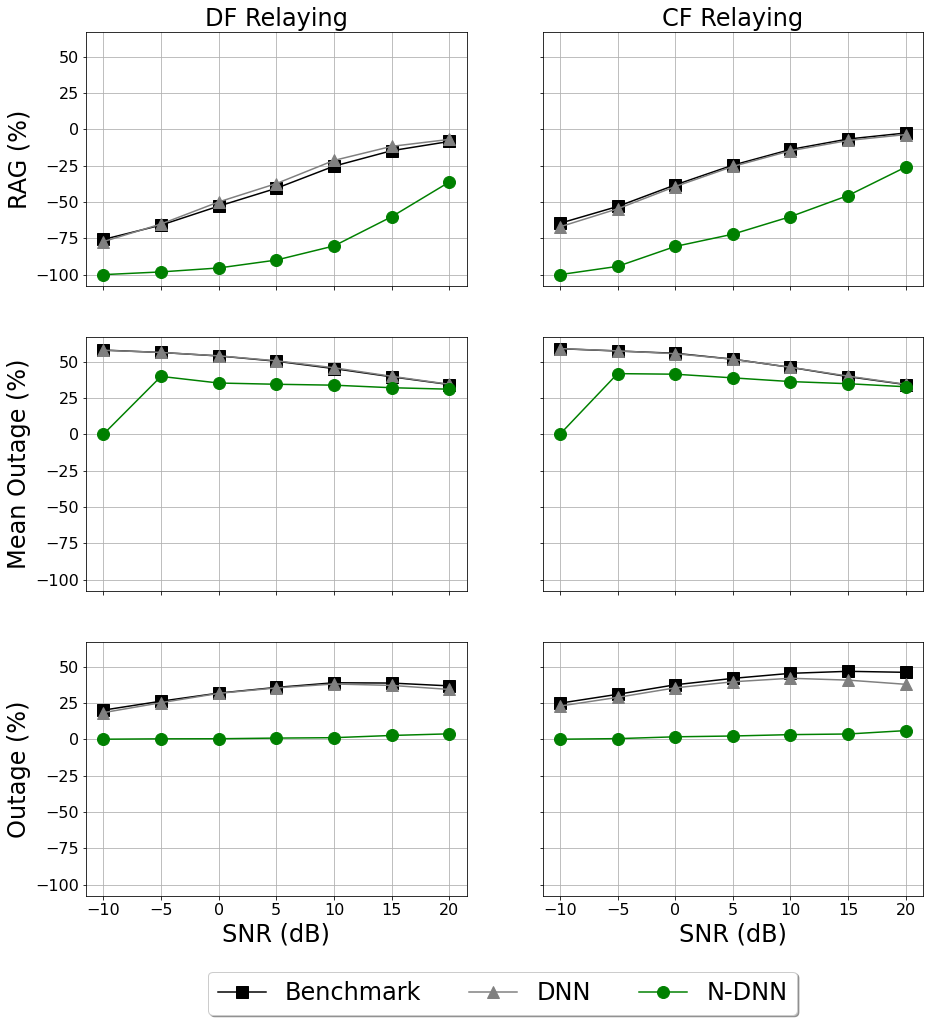

In [69]:
fig, ax = plt.subplots(3, 2,figsize=(15,15), sharex=True, sharey=True)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

ax[0][0].grid()
ax[1][0].grid()
ax[2][0].grid()


ax[0][1].grid()
ax[1][1].grid()
ax[2][1].grid()


ax[0][0].tick_params(axis='x', labelsize=16)
ax[0][1].tick_params(axis='x', labelsize=16)


ax[1][0].tick_params(axis='x', labelsize=16)
ax[1][1].tick_params(axis='x', labelsize=16)


ax[2][0].tick_params(axis='x', labelsize=16)
ax[2][1].tick_params(axis='x', labelsize=16)


ax[0][0].tick_params(axis='y', labelsize=16)
ax[0][1].tick_params(axis='y', labelsize=16)


ax[1][0].tick_params(axis='y', labelsize=16)
ax[1][1].tick_params(axis='y', labelsize=16)


ax[2][0].tick_params(axis='y', labelsize=16)
ax[2][1].tick_params(axis='y', labelsize=16)




plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

# --------------------------------DF--------------------------------------------------#

ax[0][0].set_title('DF Relaying', fontsize=24)

# 1 : 

ax[0][0].plot(SNRs_db, db_gap_DF, c = 'black',label= 'Benchmark', marker = 's',markersize=12)

ax[0][0].plot(SNRs_db, db_gap_DNN_DF, c = 'gray',label= 'DNN', marker = '^',markersize=12)

ax[0][0].plot(SNRs_db, rate_gap_dnn_DF, c = 'green',label= 'N-DNN', marker = 'o',markersize=12)

# 2 : 

ax[1][0].plot(SNRs_db, Mean_Outage_ARPD_DF, c = 'black',label= 'Bruteforce (DF)', marker = 's',markersize=12)

ax[1][0].plot(SNRs_db, Mean_Outage_ARPD_DNN_DF, c = 'gray',label= 'DNN (DF)', marker = '^',markersize=12)

ax[1][0].plot(SNRs_db, mean_outage_pard_dnn_DF, c = 'green',label= 'N-DNN (DF)', marker = 'o',markersize=12)

# 3 : 

ax[2][0].plot(SNRs_db, Outage_ARPD_DF, c = 'black',label= 'Bruteforce (DF)', marker = 's',markersize=12)

ax[2][0].plot(SNRs_db, Outage_ARPD_DNN_DF, c = 'gray',label= 'DNN (DF)', marker = '^',markersize=12)

ax[2][0].plot(SNRs_db, outage_pard_dnn_DF, c = 'green',label= 'N-DNN (DF)', marker = 'o',markersize=12)



# -----------------------------------DF-----------------------------------------------#


# -----------------------------------CF-----------------------------------------------#

ax[0][1].set_title('CF Relaying', fontsize=24)



ax[0][1].plot(SNRs_db, db_gap_CF, c = 'black',label= 'Closed-Form (CF)', marker = 's',markersize=12)

ax[0][1].plot(SNRs_db, db_gap_DNN_CF, c = 'gray',label= 'DNN (CF)', marker = '^',markersize=12)

ax[0][1].plot(SNRs_db, rate_gap_dnn_CF, c = 'green',label= 'N-DNN (CF)', marker = 'o',markersize=12)



ax[1][1].plot(SNRs_db, Mean_Outage_ARPD_CF, c = 'black',label= 'Closed-Form (CF)', marker = 's',markersize=12)

ax[1][1].plot(SNRs_db, Mean_Outage_ARPD_DNN_CF, c = 'gray',label= 'DNN (CF)', marker = '^',markersize=12)

ax[1][1].plot(SNRs_db, mean_outage_pard_dnn_CF, c = 'green',label= 'N-DNN (CF)', marker = 'o',markersize=12)



ax[2][1].plot(SNRs_db, Outage_ARPD_CF, c = 'black',label= 'Closed-Form (CF)', marker = 's',markersize=12)

ax[2][1].plot(SNRs_db, Outage_ARPD_DNN_CF, c = 'gray',label= 'DNN (CF)', marker = '^',markersize=12)

ax[2][1].plot(SNRs_db, outage_pard_dnn_CF, c = 'green',label= 'N-DNN (CF)', marker = 'o',markersize=12)


# -----------------------------------CF-----------------------------------------------#

ax[0][0].set_ylabel('RAG (%)', fontsize=24)

#ax[0][1].set_xlabel('SNR (dB)', fontsize=24) #'Noise variance','Percentage'
ax[1][0].set_ylabel('Mean Outage (%)', fontsize=24)

#ax[0][2].set_xlabel('SNR (dB)', fontsize=24) #'Noise variance','Percentage'
ax[2][0].set_ylabel('Outage (%)', fontsize=24)


ax[2][0].set_xlabel('SNR (dB)', fontsize=24) #'Noise variance','Percentage'
ax[2][1].set_xlabel('SNR (dB)', fontsize=24) #'Noise variance','Percentage'

#ax[0][0].legend(bbox_to_anchor=(2,2), loc="upper center")
#ax[0][1].legend(bbox_to_anchor=(2,2), loc="upper center")

ax[0][0].legend(bbox_to_anchor=(1.9, -2.65),
          fancybox=True, shadow=True, ncol=3, fontsize=24)

#ax[0][1].legend(bbox_to_anchor=(1, -2.8),
#          fancybox=True, shadow=True, ncol=3, fontsize=14)

fig.savefig("imperfect_CSI_DF-CF.pdf", bbox_inches='tight')

